In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from Bio.Seq import Seq
from Bio import SeqIO
import os 
from sklearn import metrics
# 读取 CSV 文件
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import os,sys
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
warnings.filterwarnings("ignore")
from pathlib import Path
import json


In [9]:
class ModelEvaluator:
    """模型评估器"""
    def __init__(self):
        self.name = "metric" 

    def evaluate_model(self, y_pred, y_test, y_pred_prob, task_type="bc"):
            
        metrics_dict = {}

        true_labels = y_test
        pred_labels = y_pred
        if task_type == "bc":
            metrics_dict.update({
                    "AUC": metrics.roc_auc_score( true_labels, y_pred_prob ),
                    "ACC": metrics.accuracy_score(true_labels, pred_labels),
                    "Precision": metrics.precision_score(true_labels, pred_labels),
                    "Recall": metrics.recall_score(true_labels, pred_labels),
                    "F1": metrics.f1_score(true_labels, pred_labels),
                    "MCC": metrics.matthews_corrcoef(true_labels, pred_labels),
                    # "sensitivity": metrics.recall_score(true_labels, pred_labels),
                    # "specificity": self._specificity(true_labels, pred_labels)
                })
        elif task_type == "mcc":
            
            metrics_dict.update({
                    "AUC": metrics.roc_auc_score( true_labels, y_pred_prob, multi_class='ovr', average='macro' ),
                    "ACC": metrics.accuracy_score(true_labels, pred_labels),
                    "Precision": metrics.precision_score(true_labels, pred_labels, average="macro"),
                    "Recall": metrics.recall_score( true_labels, pred_labels, average="macro" ),
                    "F1": metrics.f1_score(true_labels, pred_labels, average="macro"),
                    "MCC": metrics.matthews_corrcoef(true_labels, pred_labels)
                })
        
        return metrics_dict

def get_mean_eval(t5_lora_path, name=""):

    fold_10_data=[]

    for i in range(1,11):

        t5_lora_json_path = os.path.join(  "_".join( t5_lora_path.split("_")[:-1] )+f'_{i}' , f'fold_{i}_predictions.csv' )
        data = pd.read_csv( t5_lora_json_path )
        data_dict = modelEvaluator.evaluate_model(  data["y_pred"],data["y_true"], data["prob_class_1"])   # y_pred, y_test, y_pred_prob
        fold_10_data.append( data_dict )


    df = pd.DataFrame( fold_10_data ).mean().to_frame().T
    df["Method"] = name
    return df

In [3]:
def get_mean_eval(t5_lora_path, name=""):
    fold_10_data = []

    for i in range(1, 11):
        # 构造每个 fold 的路径
        t5_lora_json_path = os.path.join(
            "_".join(t5_lora_path.split("_")[:-1]) + f'_{i}',
            f'fold_{i}_predictions.csv'
        )
        data = pd.read_csv(t5_lora_json_path)
        # 假设 evaluate_model 返回一个字典：如 {'acc': 0.9, 'f1': 0.85, ...}
        data_dict = modelEvaluator.evaluate_model(data["y_pred"], data["y_true"], data["prob_class_1"])
        data_dict["Fold"] = i  # 可选：记录 fold 编号
        fold_10_data.append(data_dict)

    # 不再取平均，直接转为 DataFrame
    df = pd.DataFrame(fold_10_data)
    df["Method"] = name
    return df

In [4]:
pro_plms = {
    'prot_t5_xl_uniref50':'ProtT5',
    'esm2_t33_650M_UR50D':'ESM2',
    'prot_bert':'ProtBERT',
    'ProstT5':'ProstT5',
    'ankh-base':'Ankh-base'
}

codon_plms = {
    'CodonBERT':'CodonBERT',
    'cdsBERT':'cdsBERT',
    'Mistral-Codon-v1-117M':'Mistral-Codon',
    'encodon-80M':'Encodon',
    'huggingface_calm':'CaLM'
}


esm_plms = {
    'esm2_t6_8M_UR50D':'esm2_t6_8M_UR50D',
    'esm2_t12_35M_UR50D': 'esm2_t12_35M_UR50D',
    'esm2_t30_150M_UR50D': 'esm2_t30_150M_UR50D',
    'esm2_t33_650M_UR50D': 'esm2_t33_650M_UR50D',
    'esm2_t36_3B_UR50D': 'esm2_t36_3B_UR50D',    
}



In [5]:
modelEvaluator = ModelEvaluator()

base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"

pro_all_df = pd.DataFrame()

for plm_name,value in pro_plms.items():

    base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"
    lora_path = os.path.join( base_path, f'saved_models_{plm_name}_lora_fold_10')

    df = get_mean_eval( lora_path, name=value )

    pro_all_df = pd.concat([pro_all_df, df])


codon_all_df = pd.DataFrame()

for plm_name,value in codon_plms.items():

    base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"
    lora_path = os.path.join( base_path, f'saved_models_{plm_name}_lora_fold_10')

    df = get_mean_eval( lora_path, name=value )

    codon_all_df = pd.concat([codon_all_df, df])

all_df = pd.concat( [ codon_all_df, pro_all_df ] )

In [6]:
all_df

,AUC,ACC,Precision,Recall,F1,MCC,Fold,Method
0,0.736572,0.635569,0.580488,0.753165,0.655647,0.293050,1,CodonBERT
1,0.665618,0.620991,0.601449,0.525316,0.560811,0.231776,2,CodonBERT
2,0.748546,0.661808,0.694444,0.474684,0.563910,0.317986,3,CodonBERT
3,0.717653,0.638484,0.601190,0.639241,0.619632,0.276276,4,CodonBERT
4,0.694655,0.634503,0.603774,0.607595,0.605678,0.265090,5,CodonBERT
...,...,...,...,...,...,...,...,...
5,0.697097,0.640351,0.635659,0.518987,0.571429,0.271094,6,Ankh-base
6,0.663766,0.611111,0.581699,0.563291,0.572347,0.216042,7,Ankh-base
7,0.690286,0.619883,0.625000,0.443038,0.518519,0.228167,8,Ankh-base
8,0.665071,0.640351,0.628788,0.528662,0.574394,0.270029,9,Ankh-base


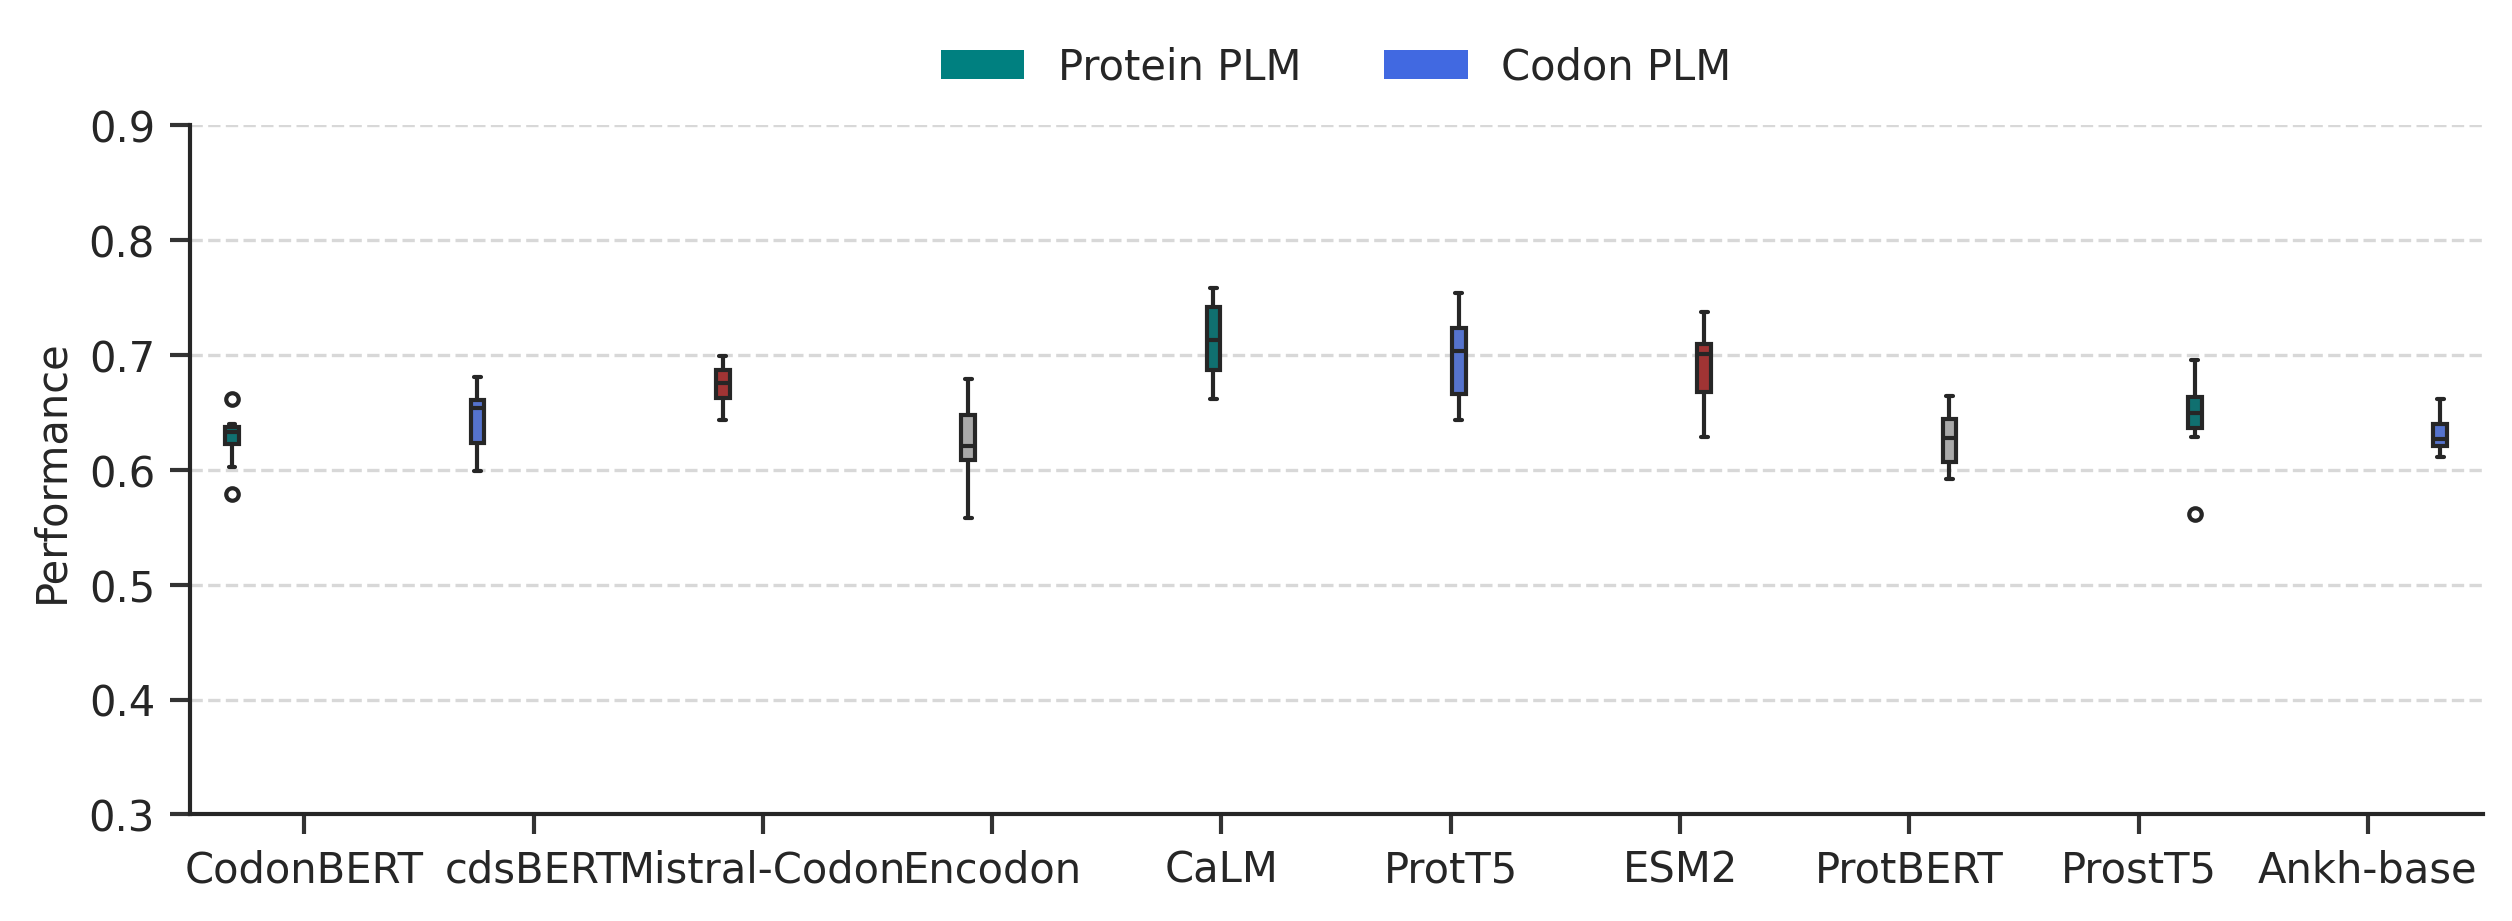

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

# 设置出版级样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
sns.set_theme(style="ticks", context="paper")

# ✅ 新的颜色方案 - 保持专业风格但与之前区分
custom_palette = [
    '#008080',  # Bright Blue - TLC-EPE
    '#4169E1',  # Purple - TLCP-EPE
    '#B22222',  # Orange - TLP-EPE
    '#A9A9A9'   # Gray - 其他（如果需要）
]

label_fontsize = 10
tick_labelsize = 10
title_fontsize = 10

# ========== 假设数据结构：all_data 应该包含每 fold 的性能，格式如下 ==========
# all_data columns: ['Method', 'Metric', 'Value']
# 例如：
#   Method       Metric     Value
#   Codon-Protein  ACC      0.72
#   Codon-Protein  ACC      0.69
#   ...

# 假设 metrics_order 是你要展示的指标顺序
# metrics_order = ['ACC', 'F1', 'AUC', 'MCC', 'Precision', 'Recall']  # 示例

# ========== 创建图形 ==========
fig, ax = plt.subplots(
    1, 1,
    figsize=(8.5, 3.8),
    dpi=300
)

# ========== 绘制箱线图（替换条形图）==========
sns.boxplot(
    x="Method", y="ACC", data=all_df,
    palette=custom_palette,
    ax=ax,
    width=0.7,
    linewidth=1.0,
    dodge=True,
    gap=0.15,
    fliersize=3,        # 控制异常点大小
    whis=1.5            # 默认四分位距倍数
)

# 设置 y 轴
ax.set_ylim(0.3, 0.9)
ax.set_yticks(np.arange(0.3, 0.91, 0.1))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.set_ylabel("Performance", fontsize=label_fontsize)
ax.set_xlabel("")

# 刻度和网格
ax.tick_params(axis='both', labelsize=tick_labelsize, color='#333333')
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

# 设置 x 轴标签（确保顺序正确）
# ax.set_xticklabels(metrics_order, rotation=0)

# 去掉上边框和右边框
sns.despine(ax=ax, top=True, right=True)

# ========== 创建横向图例（使用 Rectangle 模拟，保持与原风格一致）==========
custom_patches = [
    Rectangle((0, 0), 1, 1, facecolor=custom_palette[i], linewidth=0)
    for i in range(3)
]

labels = ['Protein PLM', 'Codon PLM']

ax.legend(
    custom_patches,
    labels,
    loc='upper center',
    ncol=3,
    fontsize=10,
    title_fontsize=11,
    frameon=False,
    bbox_to_anchor=(0.5, 1.17)
)

# ========== 布局调整 ==========
plt.tight_layout(rect=[0, 0.06, 1, 0.92])  # 为图例留出空间

# # ========== 保存 ==========
# plt.savefig("model_comparison_boxplot_single.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("model_comparison_boxplot_single.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# 设置绘图样式
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 设置颜色
colors = ['#9B2226', '#2E5894', '#006D77']

# 创建箱线图
sns.boxplot(x='Metric', y='Value', hue='Model', data=plot_df,
            palette=colors, width=0.79, showfliers=False)
sns.swarmplot(x='Metric', y='Value', hue='Model', data=plot_df,
              palette=colors, dodge=True, size=6, alpha=0.6)

# 设置图表属性
plt.xlabel('Evaluation parameters', fontsize=12, fontweight='bold')
plt.ylabel('Predicted performance', fontsize=12, fontweight='bold')
plt.ylim(0.5, 1)

# 设置图例（调整为一行）
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:3],
    labels[:3], 
    facecolor='white',
    edgecolor='black',
    fontsize=8,
    frameon=True,
    loc='center', 
    bbox_to_anchor=(0.85, 0.9),
    ncol=3  # 将图例设置为一行
)

# 设置网格
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.grid(False, axis='x')

# 设置刻度
plt.tick_params(axis='both', which='major', labelsize=10)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

In [10]:
modelEvaluator = ModelEvaluator()

base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"

pro_all_df = pd.DataFrame()

for plm_name,value in pro_plms.items():

    base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"
    lora_path = os.path.join( base_path, f'saved_models_{plm_name}_lora_fold_10')

    df = get_mean_eval( lora_path, name=value )

    pro_all_df = pd.concat([pro_all_df, df])


codon_all_df = pd.DataFrame()

for plm_name,value in codon_plms.items():

    base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"
    lora_path = os.path.join( base_path, f'saved_models_{plm_name}_lora_fold_10')

    df = get_mean_eval( lora_path, name=value )

    codon_all_df = pd.concat([codon_all_df, df])


esm_all_df = pd.DataFrame()

for esm_name,value in esm_plms.items():

    base_path = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output"
    lora_path = os.path.join( base_path, f'saved_models_{esm_name}_lora_fold_10')

    df = get_mean_eval( lora_path, name=value )

    esm_all_df = pd.concat([esm_all_df, df])



In [11]:
esm_all_df

,AUC,ACC,Precision,Recall,F1,MCC,Method
0,0.754790,0.681946,0.651937,0.680654,0.663559,0.365521,esm2_t6_8M_UR50D
0,0.759485,0.691288,0.669448,0.661715,0.661870,0.381844,esm2_t12_35M_UR50D
0,0.759274,0.682522,0.662081,0.649629,0.649762,0.365441,esm2_t30_150M_UR50D
0,0.762725,0.691578,0.672768,0.657869,0.658664,0.384826,esm2_t33_650M_UR50D
0,0.756324,0.682524,0.671110,0.619798,0.640156,0.361774,esm2_t36_3B_UR50D


In [9]:
pro_all_df

,AUC,ACC,Precision,Recall,F1,MCC,Method
0,0.763262,0.698002,0.682459,0.645787,0.661335,0.392122,ProtT5
0,0.762725,0.691578,0.672768,0.657869,0.658664,0.384826,ESM2
0,0.684347,0.626746,0.594836,0.601951,0.596317,0.250996,ProtBERT
0,0.715099,0.645731,0.615475,0.672374,0.630179,0.305313,ProstT5
0,0.688004,0.632002,0.616233,0.543098,0.574572,0.256661,Ankh-base


In [10]:
codon_all_df

,AUC,ACC,Precision,Recall,F1,MCC,Method
0,0.693724,0.627323,0.598606,0.610264,0.599744,0.255384,CodonBERT
0,0.702626,0.645137,0.650773,0.508345,0.563071,0.284235,cdsBERT
0,0.749161,0.673769,0.647772,0.641925,0.643157,0.344476,Mistral-Codon
0,0.671653,0.624108,0.590236,0.608990,0.597185,0.247373,Encodon
0,0.785882,0.712309,0.683769,0.703495,0.688741,0.426686,CaLM


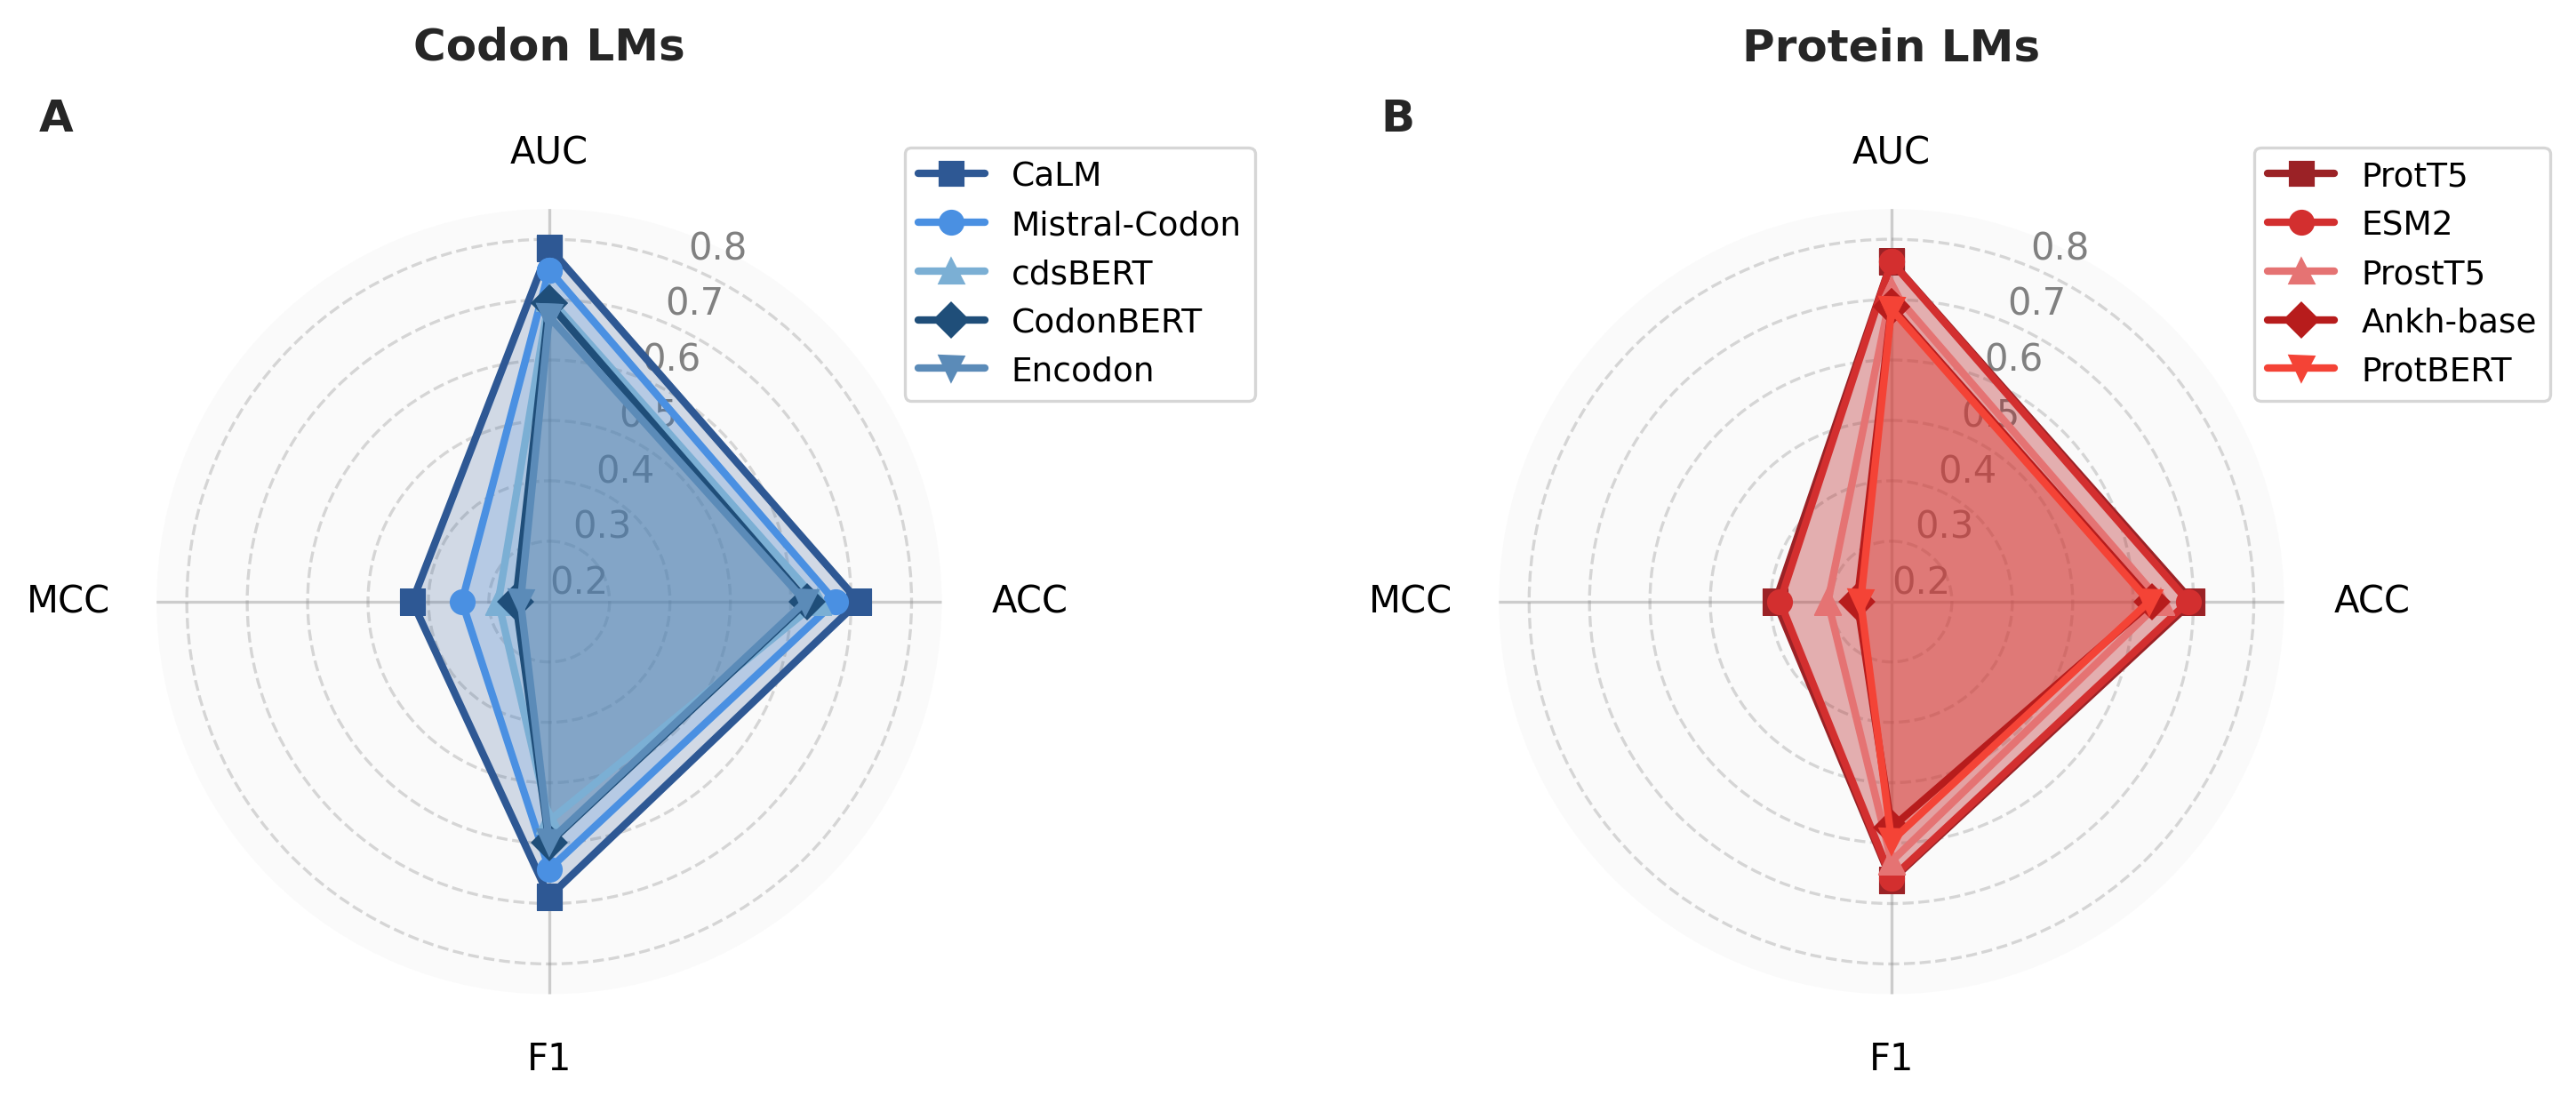

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# 设置出版级样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
sns.set_theme(style="ticks", context="paper")


# 为每个子图创建5种不同的颜色调色板
codon_colors = ['#2E5894', '#4A90E2', '#7BAFD4', '#1F4E79', '#5B8BB8']  # 蓝色系
protein_colors = ['#9B2226', '#D32F2F', '#E57373', '#B71C1C', '#F44336']  # 红色系

# 指标与角度
metrics = ['AUC', 'ACC', 'F1', 'MCC']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 闭合

# 数据（闭合）- 修复闭合方式
CaLM = [0.785882, 0.712309, 0.688741, 0.426686]
Mistral_Codon = [0.749161, 0.673769, 0.643157, 0.344476]
cdsBERT = [0.702626, 0.645137, 0.563071, 0.284235]
CodonBERT = [0.693724, 0.62732, 0.599744, 0.255384]
Encodon = [0.671653, 0.624108, 0.597185, 0.247373]

ProtT5 = [0.763262, 0.698002, 0.661335, 0.392122]
ESM2 = [0.762725, 0.691578, 0.658664, 0.384826]
ProstT5 = [0.715099, 0.645731, 0.630179, 0.305313]
Ankh_base = [0.688004, 0.632002, 0.574572, 0.256661]
ProtBERT = [0.684347, 0.626746, 0.596317, 0.250996]

# 闭合数据 - 正确的方式：将第一个点重复到最后
def close_data(data):
    return data + [data[0]]

CaLM_closed = close_data(CaLM)
Mistral_Codon_closed = close_data(Mistral_Codon)
cdsBERT_closed = close_data(cdsBERT)
CodonBERT_closed = close_data(CodonBERT)
Encodon_closed = close_data(Encodon)

ProtT5_closed = close_data(ProtT5)
ESM2_closed = close_data(ESM2)
ProstT5_closed = close_data(ProstT5)
Ankh_base_closed = close_data(Ankh_base)
ProtBERT_closed = close_data(ProtBERT)

# 创建图形和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True), dpi=300)

# 通用设置函数
def setup_ax(ax):
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_facecolor('#FAFAFA')
    # 调整Y轴范围以适应所有数据，包括MCC
    ax.set_ylim(0.2, 0.85)
    r_ticks = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    ax.set_yticks(r_ticks)
    ax.set_yticklabels([f"{t:.1f}" for t in r_ticks], fontsize=10, color='gray')
    ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax.set_xticks(angles[:-1])  # 使用不闭合的角度
    ax.set_xticklabels(metrics, fontsize=10, color='black')
    for spine in ax.spines.values():
        spine.set_visible(False)

setup_ax(ax1)
setup_ax(ax2)

# ========== 子图 1：Codon LMs ==========
models_codon = [
    ('CaLM', CaLM_closed, 's'),
    ('Mistral-Codon', Mistral_Codon_closed, 'o'),
    ('cdsBERT', cdsBERT_closed, '^'),
    ('CodonBERT', CodonBERT_closed, 'D'),
    ('Encodon', Encodon_closed, 'v')
]

for i, (name, data, marker) in enumerate(models_codon):
    ax1.plot(angles, data, marker=marker, color=codon_colors[i], linewidth=2, markersize=6, label=name)
    ax1.fill(angles, data, color=codon_colors[i], alpha=0.2)

ax1.set_title("Codon LMs", fontsize=12, fontweight='bold', pad=20)
ax1.text(-0.15, 1.1, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')


for label, angle in zip(ax1.get_xticklabels(), angles[:-1]):
    angle_deg = angle * 180 / np.pi  # 转换为度数
    # 根据角度调整标签的对齐方式
    if angle_deg == 90:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.08))
    elif angle_deg == 180:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.02))    
    elif angle_deg == 270:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.08))


# 添加图例
ax1.legend(loc='upper right', bbox_to_anchor=(1.42, 1.1), fontsize=9, labelcolor='black')

# ========== 子图 2：Protein LMs ==========
models_protein = [
    ('ProtT5', ProtT5_closed, 's'),
    ('ESM2', ESM2_closed, 'o'),
    ('ProstT5', ProstT5_closed, '^'),
    ('Ankh-base', Ankh_base_closed, 'D'),
    ('ProtBERT', ProtBERT_closed, 'v')
]

for i, (name, data, marker) in enumerate(models_protein):
    ax2.plot(angles, data, marker=marker, color=protein_colors[i], linewidth=2, markersize=6, label=name)
    ax2.fill(angles, data, color=protein_colors[i], alpha=0.2)

ax2.set_title("Protein LMs", fontsize=12, fontweight='bold', pad=20)
ax2.text(-0.15, 1.1, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')

for label, angle in zip(ax2.get_xticklabels(), angles[:-1]):
    angle_deg = angle * 180 / np.pi  # 转换为度数
    # 根据角度调整标签的对齐方式
    if angle_deg == 90:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.08))
    elif angle_deg == 180:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.02))  
    elif angle_deg == 270:
        # label.set_horizontalalignment('center')
        # label.set_verticalalignment('center')
        label.set_position((1, -0.08))


# 添加图例
ax2.legend(loc='upper right', bbox_to_anchor=(1.36, 1.1), fontsize=9, labelcolor='black')

# ========== 布局调整 ==========
plt.tight_layout(rect=[0, 0.06, 1, 0.94])
# ========== 保存图像 ==========
plt.savefig('radar_plot.png', bbox_inches='tight')  # 或 'radar_plot.png' 等

# 显示图
plt.show()
